# 第24章 模型构建

# 24.1 简介
通过上一章的学习，我们主要理解了线性模型的工作原理，本章我们不再使用模拟数据，而聚焦于真实数据，介绍如合循序渐进地建立模型以帮助我们理解数据。

## 24.1.1 准备工作

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
import patsy
from plotnine import *
#导入数据
file=['airlines','airports','flights','planes','weather']
for filename in file:  
    f=open('nycflights/%s.csv'%filename)
    globals()[filename]=pd.read_csv(f)
f=open('diamonds/diamonds.csv')
diamonds=pd.read_csv(f)

# 24.2 为什么质量差的钻石更贵
在前面的章节，我们发现钻石质量与价格间这种令人惊讶的关系：质量越差的钻石（切工差、颜色差、纯净度低）具有更高的价格:

注意，最差的钻石颜色是J（微黄），最差的纯净度是I1（肉眼可见内含物）

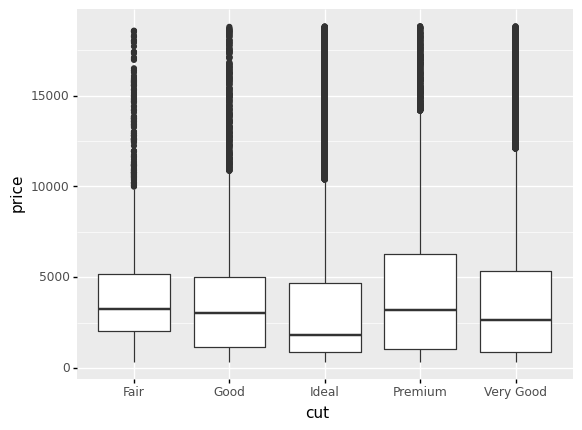

<ggplot: (143900709861)>

In [2]:
(ggplot(diamonds,aes('cut','price'))+geom_boxplot())

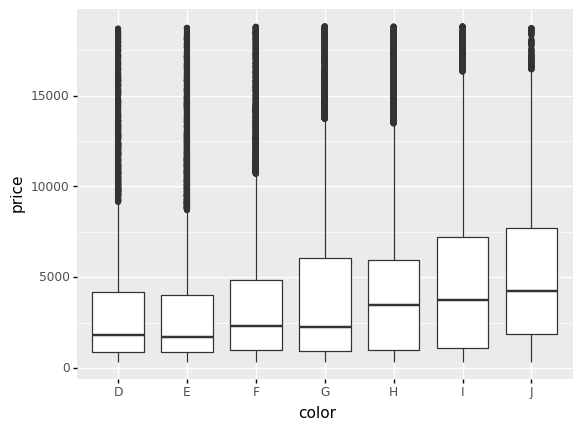

<ggplot: (143907148150)>

In [3]:
(ggplot(diamonds,aes('color','price'))+geom_boxplot())

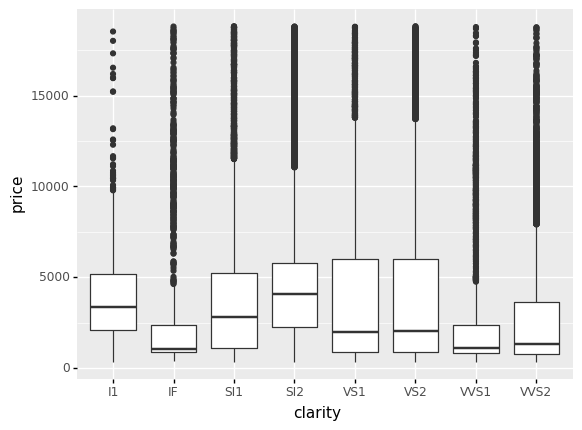

<ggplot: (143908153354)>

In [4]:
(ggplot(diamonds,aes('clarity','price'))+geom_boxplot())

## 24.2.1 价格与重量
造成质量差的钻石价格更高这一现象的原因是忽略了一个重要的混淆变量：钻石重量（carat）。重量是确定钻石价格的单一因素中最重要的一个，而质量差的钻石往往更重一点。

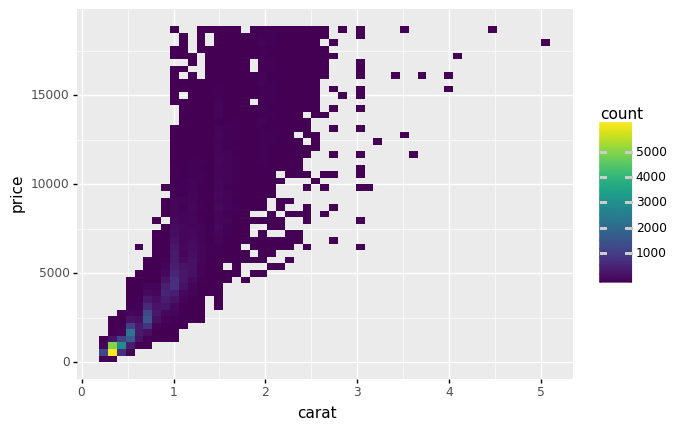

<ggplot: (143908265822)>

In [5]:
(ggplot(diamonds,aes('carat','price'))+
 geom_bin2d(bins=50))

通过你个一个模型来分离carat变量的作用，我们可以更容易看到钻石的其他特性对price的影响。但是我们首先要对数据进行一定的调整：
* 重点关注小于2.5克拉的钻石
* 对重量和价格变量进行对数转换

以上两个调整可以让我们更轻松地看到carat和price之间的关系

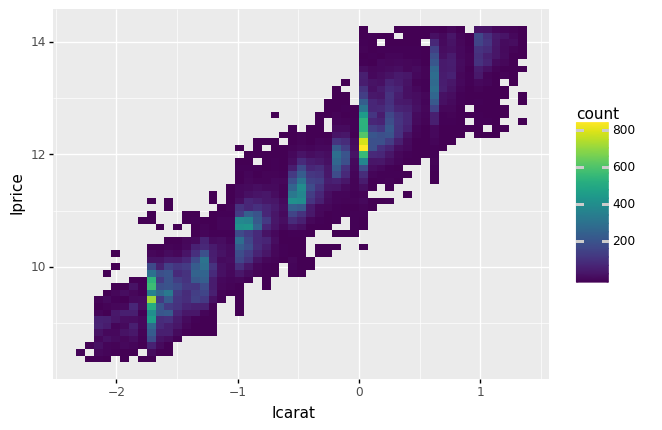

<ggplot: (143908296973)>

In [6]:
diamonds2=diamonds[diamonds['carat']<=2.5].copy()
diamonds2['lprice']=np.log2(diamonds['price'])
diamonds2['lcarat']=np.log2(diamonds['carat'])
(ggplot(diamonds2,aes('lcarat','lprice'))+
 geom_bin2d(bins=50))

对数转换在这个示例中十分重要，因为它可以让模式变为线性的，这样我们可以通过拟合一个模型去除这种强烈的线性关系：

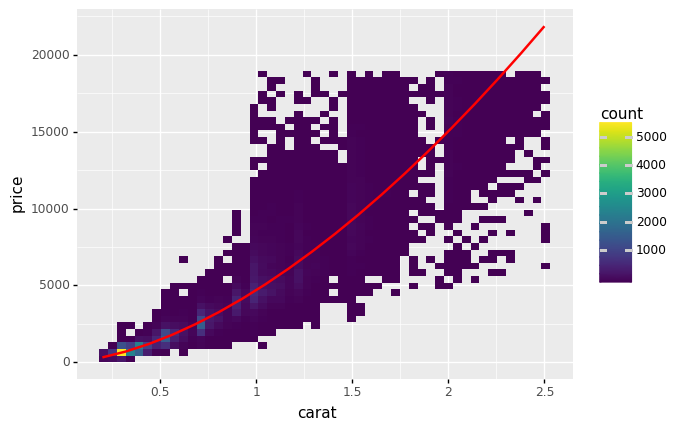

<ggplot: (143908380058)>

In [7]:
#拟合线性ols回归
mod_diamond=smf.ols(formula='lprice~lcarat',data=diamonds2).fit()
#通过自定义20个点，做出预测的数据表（还原了对数转换）
grid=pd.DataFrame({'carat':np.linspace(diamonds2.carat.min(),diamonds2.carat.max(),20)})
grid['lcarat']=np.log2(grid['carat'])
grid['price']=np.power(2,mod_diamond.predict(grid))
#将预测值覆盖在原始数据上
(ggplot(aes('carat','price'))+
 geom_bin2d(data=diamonds2,bins=50)+
 geom_line(data=grid,color='red',size=1))

如图所示，如果我们相信这个模型，那么大钻石要比预料中的便宜得多（数据大部分位于红线之下），这也可能是因为数据集中没有价格超过$19000的钻石

现在我们可以检查一下残差，用来验证我们是否成功移除了强烈的线性模式。

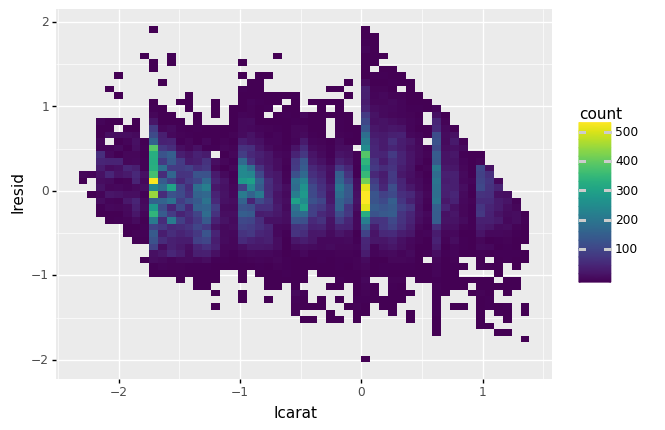

<ggplot: (143908153387)>

In [8]:
#添加残差
diamonds2['lresid']=mod_diamond.resid
#可视化
(ggplot(diamonds2,aes('lcarat','lresid'))+
 geom_bin2d(bins=50))

我们接下类可以使用残差代替price重新绘图

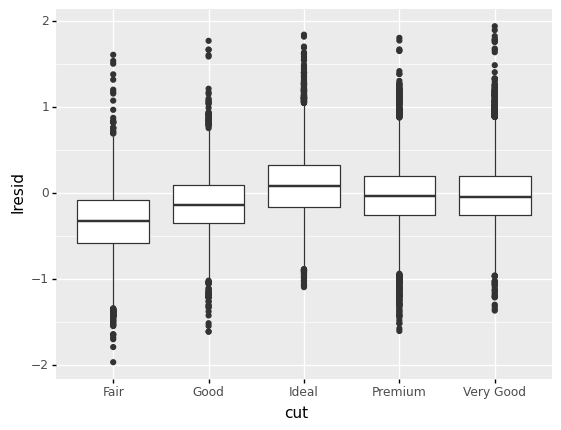

<ggplot: (143908696468)>

In [9]:
(ggplot(diamonds2,aes('cut','lresid'))+geom_boxplot())

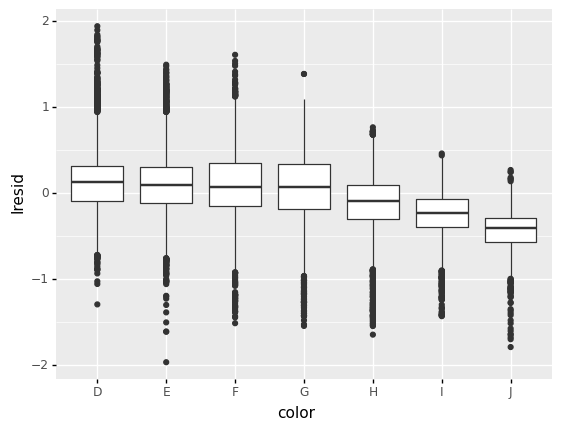

<ggplot: (143907794761)>

In [10]:
(ggplot(diamonds2,aes('color','lresid'))+geom_boxplot())

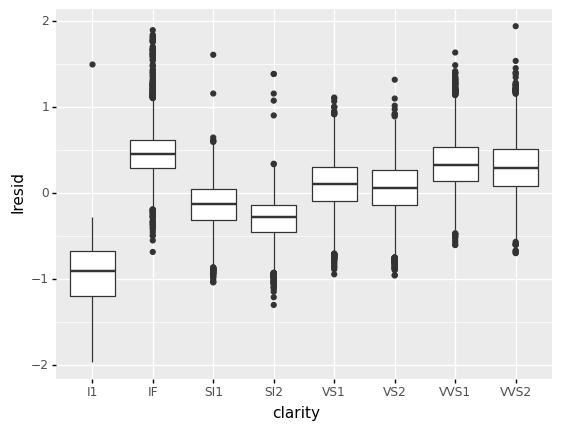

<ggplot: (143909546966)>

In [11]:
(ggplot(diamonds2,aes('clarity','lresid'))+geom_boxplot())

由于我们的模型是 formula='lprice~lcarat' 所以当对carat进行在分组与残差组合行程箱线图时，我们可以看到我们期望中的关系：当钻石质量下降时，其价格也随之下降，而那些质量越差的钻石，实际价格也将低于期望价格。

由于我们还是采用对数，所以残差为-1表示价格为预期的2^(-1)，即价格是预期价格的一半。

## 24.2.2 一个更复杂的模型
我们可以继续构建模型，例如可以把模型中包含的三个变量color，cut和clarity加入模型，将这三个分类变量的效果明确表示出来

In [12]:
mod_diamond2=smf.ols(formula='lprice~lcarat+color+cut+clarity',data=diamonds2).fit()

现在的模型中包括了4个预测变量，因此很难可视化。但是由于其彼此独立，我们可以在4张图中分别绘制他们。

由于R语言书中运用到了data.grid()函数中的.model用法，具体操作是只改变某一参数而固定其他变量，观测预测值的变化。（固定的其他变量在没有说明时默认为：若是连续变量采用中值，若是分类变量取其最常见的值）

In [13]:
#改变cut变量探究对预测值的影响
grid=pd.DataFrame({'cut':['Fair','Good','Very Good','Premium','Ideal']})
#固定另外三个变量与书中表格一致
grid['lcarat']=-0.515
grid['color']='G'
grid['clarity']='SI1'

#在mod.params表中返回对应分类变量的系数
grid['pred']=mod_diamond2.predict(grid)
grid.head()

,cut,lcarat,color,clarity,pred
0,Fair,-0.515,G,SI1,10.989047
1,Good,-0.515,G,SI1,11.103982
2,Very Good,-0.515,G,SI1,11.157439
3,Premium,-0.515,G,SI1,11.189748
4,Ideal,-0.515,G,SI1,11.221070


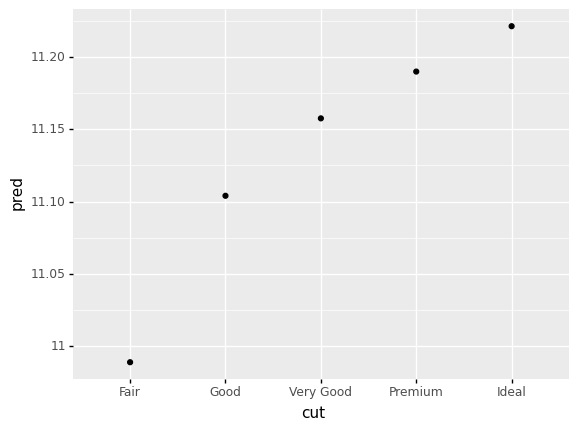

<ggplot: (143909759223)>

In [14]:
#将grid的cut分组设为category类型，并重新定义字符串排序
grid['cut']=pd.Categorical(grid['cut'],categories=['Fair','Good','Very Good','Premium','Ideal'],ordered=True)
#可视化
(ggplot(grid)+
 geom_point(mapping=aes('cut','pred')))

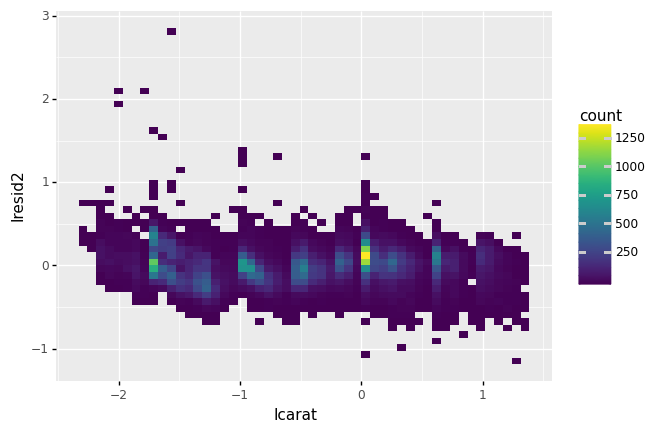

<ggplot: (143909769683)>

In [15]:
diamonds2['lresid2']=mod_diamond2.resid
(ggplot(diamonds2,aes('lcarat','lresid2'))+
 geom_bin2d(bins=50))

此图说明在拟合上述模型后，一些钻石有非常大的残差。因为残差为2表示钻石的价格时预计价格的4倍，所以我们通常还要检验一下异常值。

In [16]:
diamonds3=diamonds2[np.abs(diamonds2['lresid2'])>1].copy()
diamonds3['pred']=np.power(2,mod_diamond2.predict(diamonds3))
pd.concat([diamonds3[['price','pred']],diamonds3.loc[:,'carat':'table'],diamonds3.loc[:,'x':'z']],axis=1).sort_values(by='price')

,price,pred,carat,cut,color,clarity,depth,table,x,y,z
38153,1013,264.333448,0.25,Fair,F,SI2,54.4,64.0,4.30,4.23,2.32
41019,1186,284.481156,0.25,Premium,G,SI2,59.0,60.0,5.33,5.28,3.12
41020,1186,284.481156,0.25,Premium,G,SI2,58.8,60.0,5.33,5.28,3.12
41918,1262,2644.253019,1.03,Fair,E,I1,78.2,54.0,5.72,5.59,4.42
43424,1415,638.847582,0.35,Fair,G,VS2,65.9,54.0,5.57,5.53,3.66
43425,1415,638.847582,0.35,Fair,G,VS2,65.9,54.0,5.57,5.53,3.66
45865,1715,576.108418,0.32,Fair,F,VS2,59.6,60.0,4.42,4.34,2.61
46476,1776,412.028257,0.29,Fair,F,SI1,55.8,60.0,4.48,4.41,2.48
49773,2160,313.777026,0.34,Fair,F,I1,55.8,62.0,4.72,4.60,2.60
51369,2366,774.498030,0.30,Very Good,D,VVS2,60.6,58.0,4.33,4.35,2.63


这个结果没有太大价值……但或许我们可以花点时间思考一下出现异常值是因为模型有问题还是数据中有错误。如果时数据有错误，那么我们就有机会买到那些低错误定价的钻石，卖出那些高错误定价的钻石。

# 24.3 哪些因素影响了每日航班数量
我们使用相同的流程来处理更为简单的一个数据集：每天从纽约市出发的航班数量。因为其只有365行和2列，而且我们也不准备充分实现最终模型。首先，我们需要计算每天出发的航班数量，并进行可视化。

In [17]:
daily=flights.groupby(['year','month','day'])['day'].agg({('n','count')}).reset_index()
daily['date']=pd.to_datetime(daily[['year','month','day']])
daily=daily[['date','n']]
daily

,date,n
0,2013-01-01,842
1,2013-01-02,943
2,2013-01-03,914
3,2013-01-04,915
4,2013-01-05,720
...,...,...
360,2013-12-27,963
361,2013-12-28,814
362,2013-12-29,888
363,2013-12-30,968


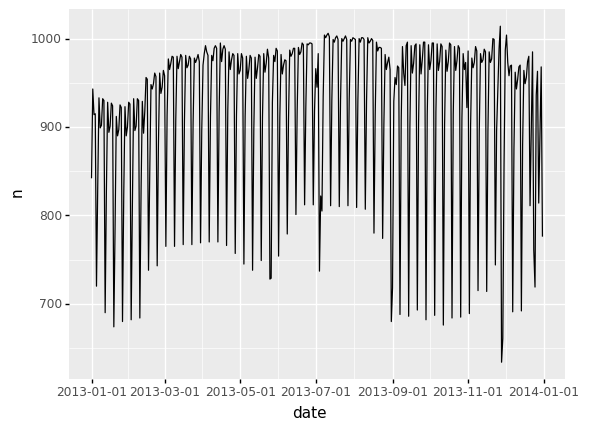

<ggplot: (143909760985)>

In [18]:
(ggplot(daily,aes('date','n'))+
 geom_line())

## 24.3.1 一周中的每一天
理解长期趋势是非常困难的，因为数据中存在强烈的周内效应，它严重影响了数据中的微妙模式。我们首先检查一下航班数量在一周中每一天的分布。

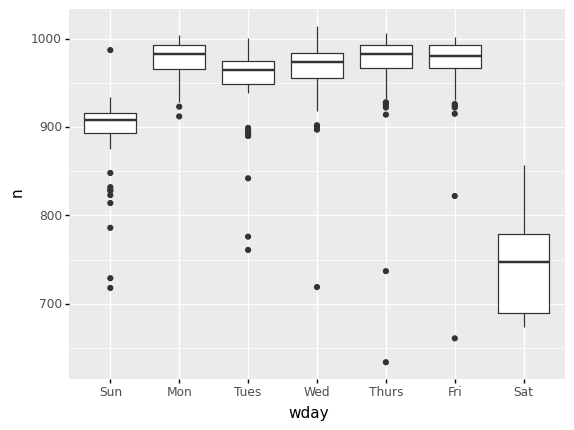

<ggplot: (143908830937)>

In [19]:
#返回一组时间序列的周内位置
def wday(arr_date):
    dlist=['Sun','Mon','Tues','Wed','Thurs','Fri','Sat']
    map_name=pd.Series(dlist,index=[6,0,1,2,3,4,5])
    arr_wday=pd.Categorical(arr_date.dt.dayofweek.map(map_name),categories=dlist,ordered=True)
    return arr_wday
daily['wday']=wday(daily['date'])
#可视化
(ggplot(daily,aes('wday','n'))+
 geom_boxplot())

周末的航班数量比较少，因为多数行程是由于公务出差。去除这一种模式的方法是使用模型。首先我们拟合这个模型，并将预测值覆盖在原始数据上。

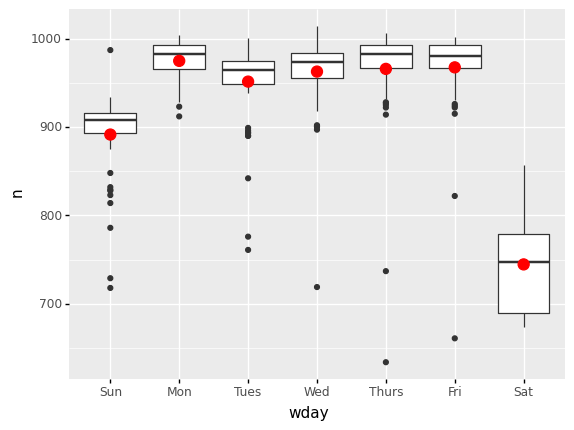

<ggplot: (143909694242)>

In [20]:
#拟合模型
mod=smf.ols(formula='n~wday',data=daily).fit()
#数据覆盖
grid=daily.copy()
grid['n']=mod.predict()
grid=grid.drop_duplicates(keep='first',subset=['wday','n'])
#可视化
(ggplot(aes('wday','n'))+
 geom_boxplot(data=daily)+
 geom_point(data=grid,color='red',size=4))

然后计算残差，并对其进行可视化表示：

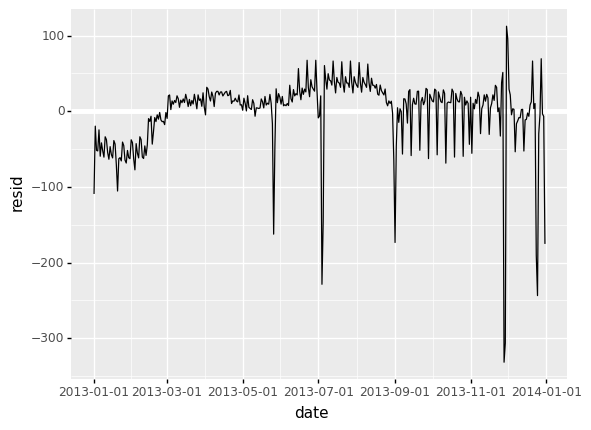

<ggplot: (143909726281)>

In [21]:
daily['resid']=mod.resid
(ggplot(daily,aes('date','resid'))+
 geom_hline(yintercept=0,size=2,color='white')+
 geom_line())

注意y轴的变化：现在它表示每天的航班数量与给定一周中某天预期航班数量间的偏差。

而且我们可以看出模型似乎从6月开始失效，因为此时数据中仍然存在一种强烈的、有规律的模式，这是我们没有捕获到的。

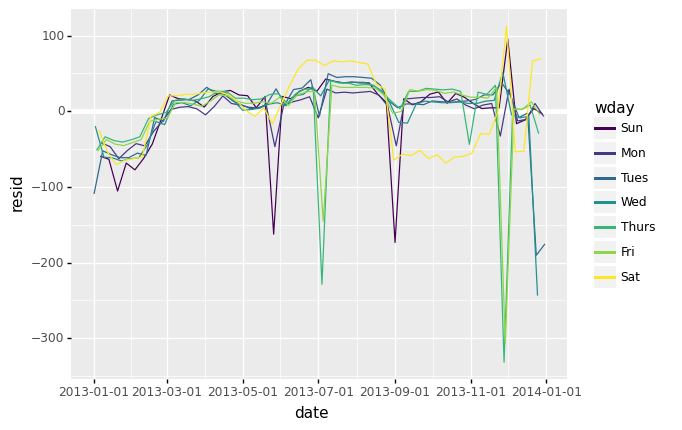

<ggplot: (143909672364)>

In [22]:
(ggplot(daily,aes('date','resid',color='wday'))+
 geom_hline(yintercept=0,size=2,color='white')+
 geom_line())

总的来说，我们的模型没有精确地预测出星期六的航班数量：夏季的实际航班数量比我们预计的要多，秋季的要少。

而且有几天的航班数量远远少于预期：

In [23]:
daily[daily['resid']<-100]

,date,n,wday,resid
0,2013-01-01,842,Tues,-109.358491
19,2013-01-20,786,Sun,-105.480769
145,2013-05-26,729,Sun,-162.480769
184,2013-07-04,737,Thurs,-228.750000
185,2013-07-05,822,Fri,-145.461538
243,2013-09-01,718,Sun,-173.480769
331,2013-11-28,634,Thurs,-331.750000
332,2013-11-29,661,Fri,-306.461538
357,2013-12-24,761,Tues,-190.358491
358,2013-12-25,719,Wed,-243.692308


当然这些特殊之包括了美国的新年、7月4日、感恩节和圣诞节，以及其他一些没有对应公共假期的日期。

从整年来看，似乎存在某种更平滑的长期趋势：

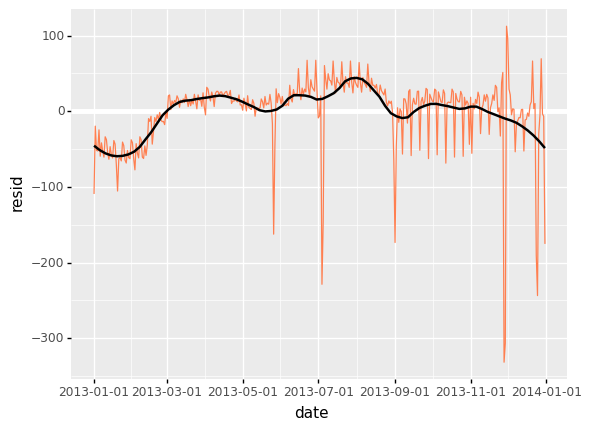

<ggplot: (143909761000)>

In [24]:
(ggplot(daily,aes('date','resid'))+
 geom_hline(yintercept=0,size=2,color='white')+
 geom_line(color='coral')+
 geom_smooth(se=False,span=0.20))

可以看出，1月和12月的航班数量较少，夏季（5-9月）的航班比较多。我们不能对这种模式进行更多量化处理，因为我们只有一年的数据。

## 24.3.2 季节性星期六效应
我们先解决未能精确预测星期六航班数量的问题。

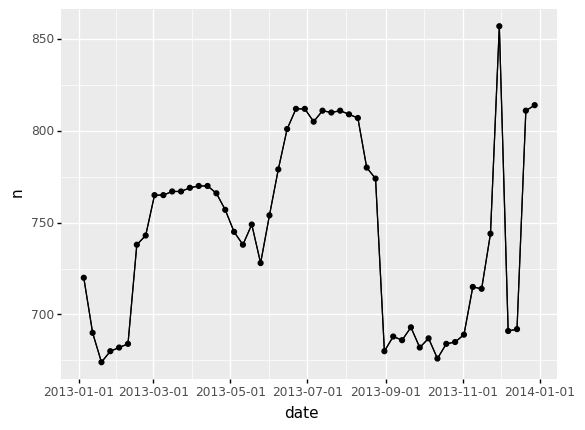

<ggplot: (143908820679)>

In [25]:
(ggplot(daily[daily['wday']=='Sat'],aes('date','n'))+
 geom_point()+
 geom_line()+
 geom_line())

我们怀疑这种模式是由暑假造成的：很多人夏季出去度假，而假期中人们是不介意在周六出行的。而为什么春季周六航班比秋季多，可能原因是他们较少在秋季安排全家度假，因为还有很长的感恩节和圣诞节的假期。（还算合理的解释）

接下类我们创建一个“term”变量来粗略表示学校的3个学期，然后使用可视化检验这样做的效果：

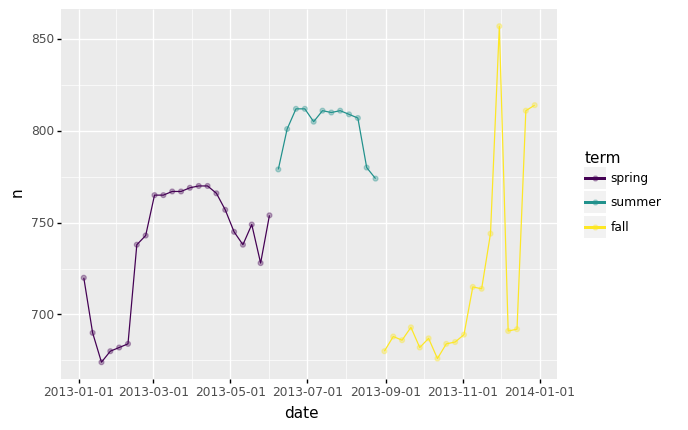

<ggplot: (143909549279)>

In [26]:
#返回某个日期所属的term
def term(date):
    if date <= datetime(2013,6,5):
        return 'spring'
    elif date <= datetime(2013,8,25):
        return 'summer'
    else:
        return 'fall'   
daily['term']=pd.Categorical(daily['date'].map(term),categories=['spring','summer','fall'],ordered=True)

(ggplot(daily[daily['wday']=='Sat'],aes('date','n',color='term'))+
 geom_point(alpha=1/3)+
 geom_line())

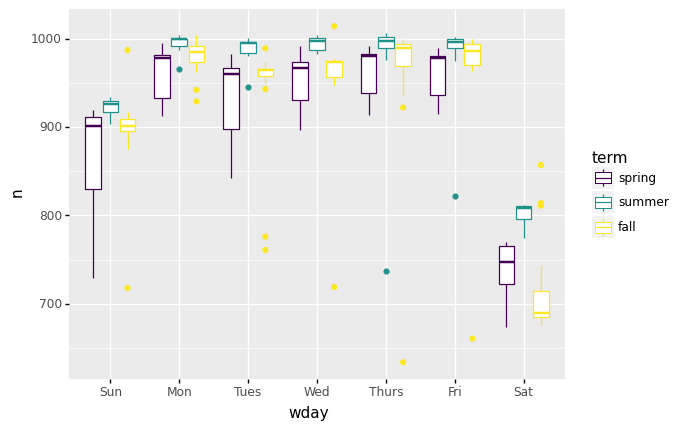

<ggplot: (143913699756)>

In [27]:
(ggplot(daily,aes('wday','n',color='term'))+
 geom_boxplot())

如图所示，不同学期间的差别还是非常大的，因此应该拟合扣除每个学期周内效应的模型。这样可以改进模型，但是效果不佳：

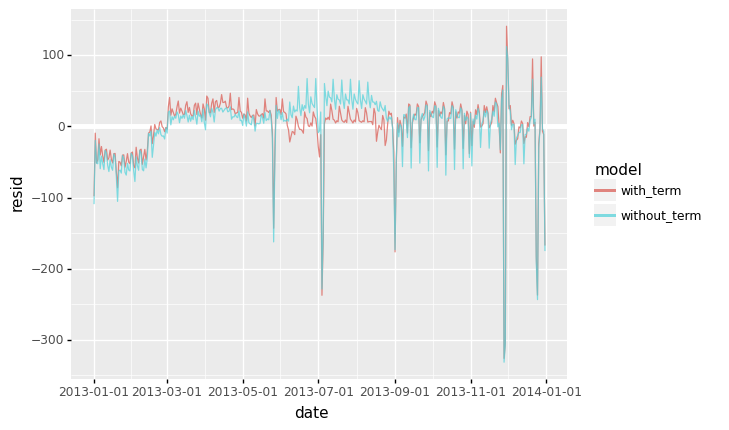

<ggplot: (143908198223)>

In [28]:
#拟合模型
mod1=smf.ols(formula='n~wday',data=daily).fit()
mod2=smf.ols(formula='n~wday*term',data=daily).fit()
#返回两个不同模型的残差
resid=pd.DataFrame({'date':daily['date'],
                    'without_term':mod1.resid,
                    'with_term':mod2.resid})
resid=resid.melt(id_vars='date',var_name='model',value_name='resid')
#可视化
(ggplot(resid,aes('date','resid',color='model'))+
 geom_hline(yintercept=0,size=2,color='white')+
 geom_line(alpha=0.75))

将预测数据覆盖在原始数据上我们就能看到问题：

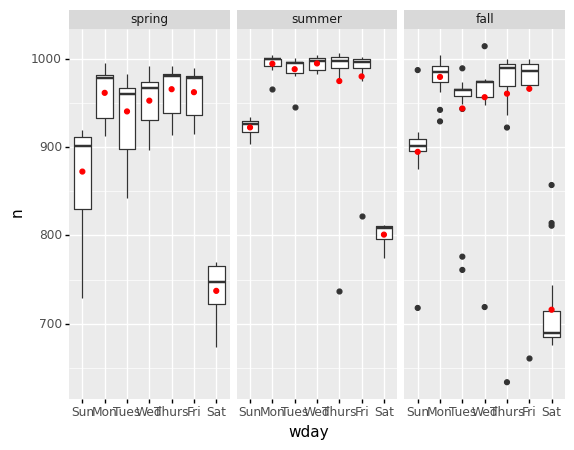

<ggplot: (143907839157)>

In [29]:
#覆盖原始数据
grid=daily[['wday','term']].copy()
grid['n']=mod2.predict()
grid=grid.drop_duplicates(keep='first',subset=['wday','term'])
#可视化
(ggplot(aes('wday','n'))+
 geom_boxplot(data=daily)+
 geom_point(data=grid,color='red')+
 facet_wrap('~term'))

由于模型寻找的是平均效应，但是我们数据中存在大量的离群点，因此平均趋势与典型值之间的差据比较大。我们可以用稳健的线性回归模型去改善这个问题：

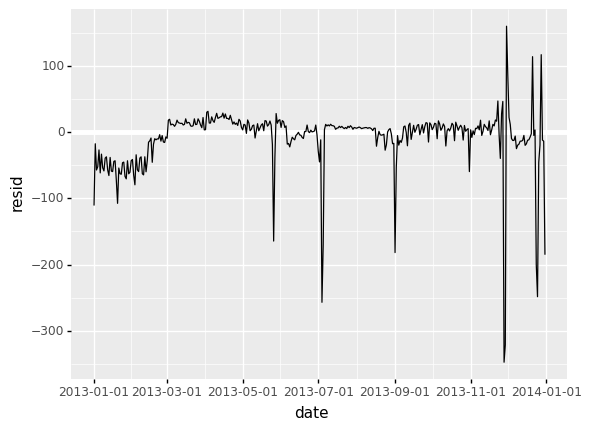

<ggplot: (143908124407)>

In [30]:
#稳健线性回归拟合
mod3=smf.rlm(formula='n~wday*term',data=daily).fit()
#可视化
daily['resid']=mod3.resid
(ggplot(daily,aes('date','resid'))+
 geom_hline(yintercept=0,size=2,color='white')+
 geom_line())

## 24.3.3 计算出的变量
如果正在试验多个模型和多个可视化方法，那么你可以将创建变量的所有代码打包放在一个函数中。

In [31]:
#直接返回某矩阵学期和周内位置
def compute_vars(data,time_name='date'):
    data['term']=data[time_name].map(term)
    data['wday']=wday(data[time_name])
df=daily[['date']].copy()
df

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
360,2013-12-27
361,2013-12-28
362,2013-12-29
363,2013-12-30


In [32]:
compute_vars(df)
df

,date,term,wday
0,2013-01-01,spring,Tues
1,2013-01-02,spring,Wed
2,2013-01-03,spring,Thurs
3,2013-01-04,spring,Fri
4,2013-01-05,spring,Sat
...,...,...,...
360,2013-12-27,fall,Fri
361,2013-12-28,fall,Sat
362,2013-12-29,fall,Sun
363,2013-12-30,fall,Mon


## 24.3.4 年度时间：另一种方法
我们已经使用了美国学校学期对旅行的影响来改进模型。改进模型的另一种方法是赋予数据更多的发言权。可以使用另一种更灵活的模型来捕获我们所关注的模式。简单的线性趋势已经无法满足我们的需要了，所以我们尝试使用三次自然样条拟合一个年度平滑曲线模型。（在使用三次自然样条插值时候R语言中的splines包的ns（）函数对应着python里patsy包中cr（）函数）

但是出现以下问题：
* R语言中可以将date数据类型的变量直接作为参数放入模型中（可以自动转换为int类型数据，但是具体转换形式不清楚），但是python不行，所以在处理时直接将R中自动转换的int数据覆盖为daily.date列，确保数据一致。
* ns()函数与cr()函数在输入相同参数后获取分组后的expansion basic matrix的结果不太一样，具体差异没有找到…但是有数学推导三次自然样条拟合的expansion basic matrix过程（https://stats.stackexchange.com/questions/172217/why-are-the-basis-functions-for-natural-cubic-splines-expressed-as-they-are-es?answertab=active#tab-top）
* 在作图的时候，教材上的分组采用的是时间对齐的“假想”数据，而本文档采用的是真实数据。

In [33]:
test=daily.copy()
#将时间数据覆盖为R语言自动转换的int数据
test['date']=np.linspace(15706, 16070, daily.shape[0])
#获取样条插值分组后的expansion basic matrix
X=patsy.dmatrix("wday*cr(date,df=5)",test)
y=np.array(test['n'])
#通过sm中的稳健线性回归函数拟合
mod=sm.RLM(y,X).fit()

In [34]:
daily['pred']=mod.predict()
grid=daily.copy()
#每个分组取13个数据
def f(df):
    return df.iloc[list(np.linspace(0,len(df)-1,13,dtype=int)),:]
grid=grid.groupby('wday').apply(f)

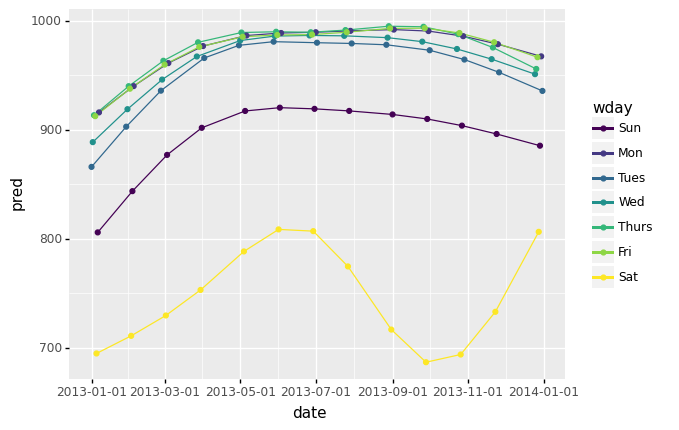

<ggplot: (143907818569)>

In [35]:
(ggplot(grid,aes('date','pred',color='wday'))+
 geom_line()+
 geom_point())

如图所示，我们依然能够看到在周六航班中的强烈的模式。通过不同的方法得到相同的信号，是一种很好的迹象。

# 24.4 学习更多的模型知识